In [1]:
import os
import dotenv
import validmind as vm
dotenv.load_dotenv()

True

# External Test Provider Demo

##  Outline

   * [Introduction](#Introduction)
---
1. [Creating a New/Custom Test]()
    * [New Test Creation](#New-Test-Creation)
---
2. [External Test Providers](#External-Test-Providers)
    * [Test Provider Flow Diagram](#Test-Provider-Flow-Diagram)
    * [Local Test Provider](#Local-Test-Provider)
    * [Github Repo Test Provider](#Github-Repo-Test-Provider)
    * [New Test Registration](#New-Test-Registration)
---
3. [Preview and Run Template Tests]()
    * [Template Updates](#Template-Updates)
    * [Template Execution](#Template-Execution)

# Introduction

This notebook demonstrates how to use a custom test provider to be able to use custom tests with the Validmind Developer Framework.
In the notebook, we load a couple different demo test providers and register them with the Validmind framework to be able to run a template that utilizes those tests.

### Background

As a user of the ValidMind developer framework, validating and documenting a new model will require finding the metrics and threshold tests that suite your specific use case. `list_tests` can help you find and use the metrics and threshold tests that are packaged within the developer framework. But what if you cannot find the test you want?

In this case, I want to find and use an Isolation Forest Metric for my data. To see if that is available within Validmind I can run the following:

In [2]:
vm.tests.list_tests(filter="outliers")

Test Type,Name,Description,ID
ThresholdTest,TimeSeriesOutliers,Test that find outliers for time series data using the z-score method,validmind.data_validation.TimeSeriesOutliers


As you can see above, we do not have one available. So now, I can go through the steps for adding a custom test to be able to use an Isolation Forest metric within my model documentation.

# New Test Creation

Defining a new test is as simple as creating a new Validmind `Metric` or `ThresholdTest` class with a `run()` method (and optionally a `description()` and `summary()` method) that runs the code and returns the result of the test.

### Test Class Definition

In [3]:
import itertools
from dataclasses import dataclass

import seaborn as sns
#Importing IsolationForest module
from sklearn.ensemble import IsolationForest

from validmind.vm_models import Figure, Metric


@dataclass
class MyIsolationForest(Metric):
    """
    Isolation Forest.
    This class implements the Isolation Forest algorithm for anomaly detection.
    Attributes:
        name (str): The name of the Isolation Forest.
        default_params (dict): The default parameters for the Isolation Forest.
        required_context (list): The required context for running the Isolation Forest.

    Methods:
        description(): Returns the description of the Isolation Forest.
        run(): Runs the Isolation Forest algorithm.
    """

    name = "isolation_forest"
    default_params = {"random_state": 0,
                      "contamination" : 0.1,
                      "features_columns": None}    
    required_context = ["dataset"]

    def description(self):
        return """
        The Isolation Forest test is an algorithm used for anomaly detection in datasets. It is based
        on the concept of isolating anomalies rather than identifying normal data points. The test builds an ensemble
        of isolation trees, which are binary trees created by randomly selecting features and splitting the data based
        on random thresholds.

        The main idea behind the Isolation Forest test is that anomalies are likely to be isolated quickly in these trees
        compared to normal instances. Anomalies are expected to have shorter average path lengths in the trees,
        as they are different from the majority of the data points.

        It's important to note that the Isolation Forest test assumes anomalies are less frequent and have different properties
        compared to normal instances. However, it may not be as effective in detecting anomalies that are close to each other
        or in datasets where anomalies are more prevalent."""

    def run(self):

        if self.params["features_columns"] is None:
            features_list = self.dataset.get_features_columns()
        else:
            features_list = self.params["features_columns"]

        # Check if all elements from features_list are present in the feature columns
        all_present = all(
            elem in self.dataset.get_features_columns() for elem in features_list
        )
        if not all_present:
            raise ValueError(
                "The list of feature columns provided do not match with "
                + "training dataset feature columns"
            )
        
        dataset = self.dataset.df

        # Training with isolation forest algorithm
        clf = IsolationForest(random_state=self.params["random_state"], contamination=self.params["contamination"])
        clf.fit(dataset)
        y_pred = clf.predict(dataset)
        
        # test passes if there aren't any outliers
        passed = not any(y_pred == -1)
        test_figures = []
        combination_pairs = list(itertools.combinations(features_list, 2))
        for feature1, feature2 in combination_pairs:
            fig = plt.figure(figsize=(10,7.5))
            ax = sns.scatterplot(data=dataset, x=feature1, y=feature2, hue=y_pred, palette="bright")
            handles, labels  =  ax.get_legend_handles_labels()
            labels = list(map(lambda x: x.replace('-1', 'Outliers'), labels))
            labels = list(map(lambda x: x.replace('1', 'Inliers'), labels))
            ax.legend(handles, labels)
            # Do this if you want to prevent the figure from being displayed
            plt.close("all")

            test_figures.append(
                Figure(
                for_object=self,
                key=f"{self.name}:{feature1}_{feature2}",
                figure=fig,
                )
            )

        return self.cache_results(figures=test_figures)

# External Test Providers

Now that we have created a new test, how do we start making use of it in the Validmind framework? This is where our new External Test Provider feature comes in. As users of the framework develop their own tests which will live outside of the framework source code, how will those tests get seamlessly plugged into the framework? The answer is through the use of a `ExternalTestProvider` class. We provide two test provider implementations out of the box, one that will load tests from a local directory and one that will load tests from a Github repository. Each can be configured to point to where the tests are located and then registered with the Validmind framework under a namespace. Once registered, the framework will be able to identify content IDs in templates that are associated with the namespace and will be able to then load the tests matching those IDs using the test provider.

### Test Provider Flow Diagram

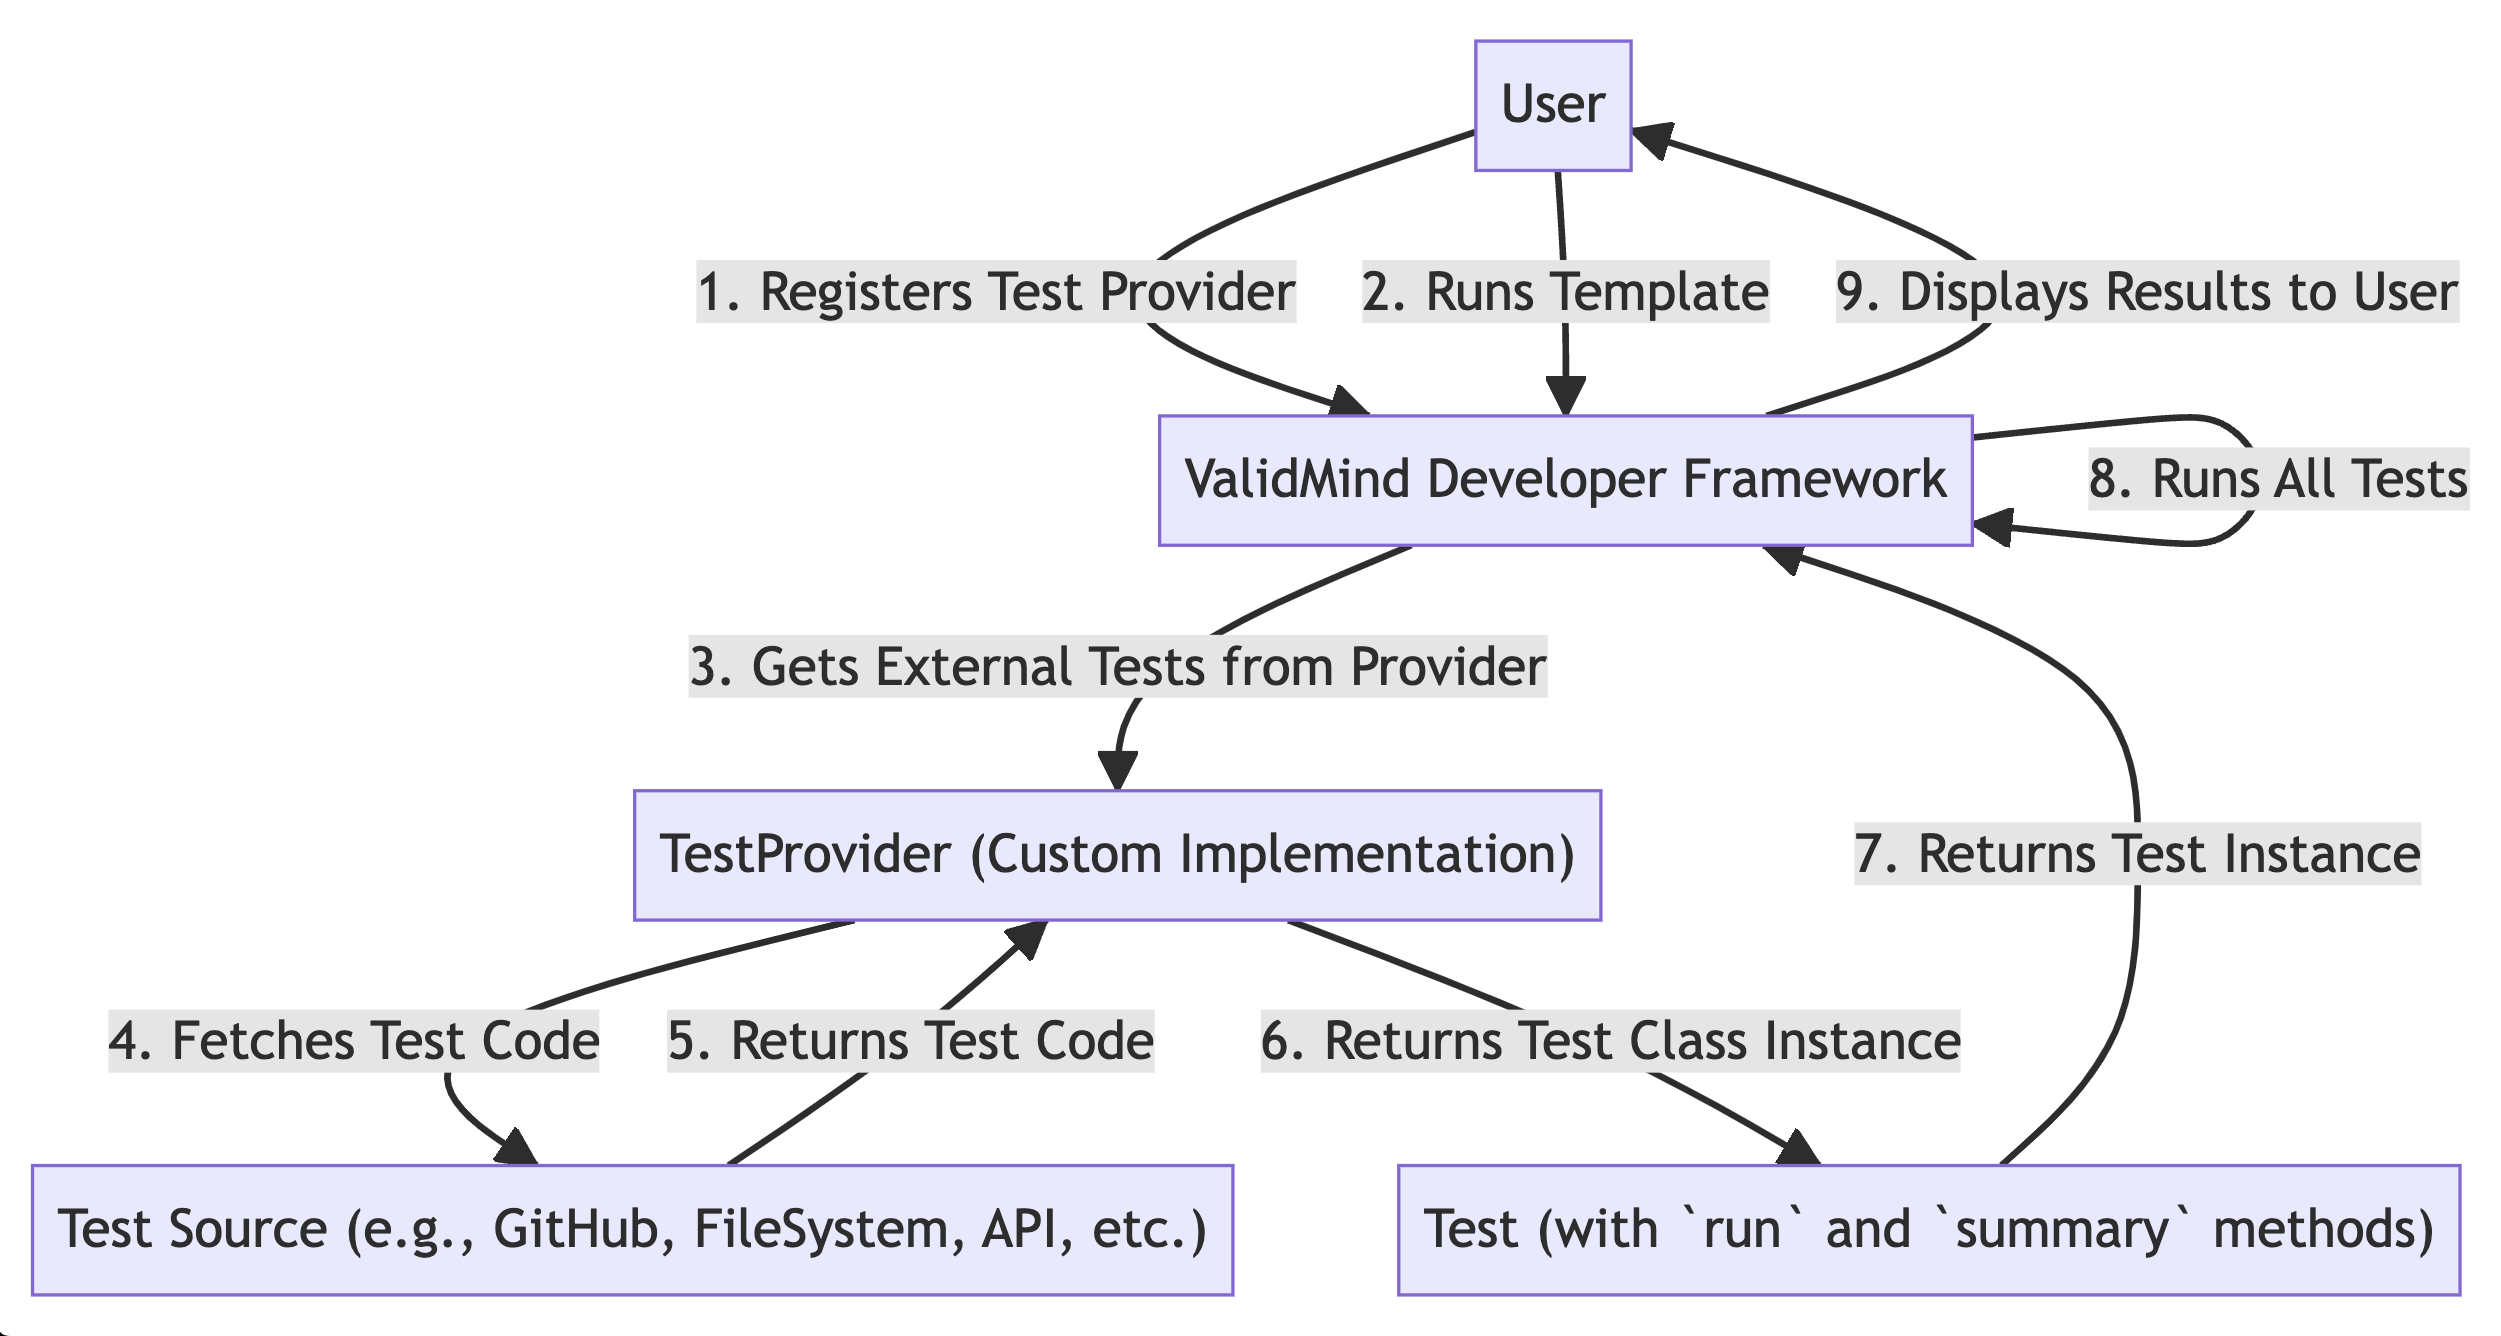

### Local Test Provider

For the Local Filesystem provider, we will just need to specify the root folder under which the provider class will look for tests.

In [4]:
from validmind.tests import LocalTestProvider, register_test_provider

local_test_provider = LocalTestProvider(root_folder="./tests")

register_test_provider(
    namespace="my_local_provider",
    test_provider=local_test_provider,
) # validmind will now call the `LocalTestProvider.load_test` method whenever it encounters a test ID that starts with `my_local_provider`

### Github Repo Test Provider

For the Github provider, we will need to specify the `org` and `repo` to pull from as well as optionally pass a `token` if the repo is private.

In [5]:
from validmind.tests import GithubTestProvider, register_test_provider

github_test_provider = GithubTestProvider(
    org="validmind",
    repo="ExternalTestProviderDemo",
    token=os.environ["GITHUB_TOKEN"],
)

register_test_provider(
    namespace="my_github_provider",
    test_provider=github_test_provider,
) # validmind will now call the `GithubTestProvider.load_test` method whenever it encounters a test ID that starts with `my_github_provider`

# New Test Registration

To "register" new tests that users have created, we mean adding it to a test provider. Now, we have defined two test providers above and we could add our new Isolation Forest Test to either. But lets go ahead and add it to our Local Test Provider. If we wanted to "register" it with our Github test provider, we would just need to add it to the repository that it points to. Once there, it can be immediately used by adding it to any template.

<i>Copy the above code into a new file called MyIsolationForest.py in the `./tests` folder</i>

# Template Updates

As explained, lets go ahead and update one of our templates with the following YAML:

```yaml
      - content_type: metric
        content_id: my_local_provider.MyIsolationForest
      - content_type: metric
        content_id: my_github_provider.tests.MyDatasetDescription
```

Notice how the `content_id` references the namespace and location of the test. This is how the framework will know which test provider has the test and in turn, the test provider will know where the test is located.

# Template Execution

Now that everything is setup and registered, we can go ahead and execute our template and see the results. We should see the results of our custom test in the output.

### Set up the Validmind connection

In [6]:
import validmind as vm

import xgboost as xgb

vm.init(
    api_host = "http://localhost:3000/api/v1/tracking",
    project = "cljeaos2k00h92fpokeocsniy"
)

2023-06-28 11:34:12,367 - INFO - api_client - Connected to ValidMind. Project: JPMC Demo Project (cljeaos2k00h92fpokeocsniy)


### Preview the template for the current project to validate that it looks correct

We now have the ability to view the template for the current project using the developer framework.

In [7]:
# we should see an `External Test Providers` section with two content blocks pointing to the two test providers we registered above
vm.preview_template()

Accordion(children=(Accordion(children=(HTML(value='<p>Empty Section</p>'), Accordion(children=(HTML(value='<p…

### Running the template

We also have the ability to run a template from the developer framework. It will use the external test providers to load and run external tests alongside the built-in Validmind tests.

In [8]:
import numpy as np
import pandas as pd

N = 100000

# Generate normally distributed data for 6 features, with different means and standard deviations
f1 = np.random.normal(loc=0, scale=1, size=N)
f2 = np.random.normal(loc=5, scale=5, size=N)
f3 = np.random.normal(loc=10, scale=10, size=N)
f4 = np.random.normal(loc=20, scale=20, size=N)
f5 = np.random.normal(loc=-10, scale=30, size=N)
f6 = np.random.normal(loc=-20, scale=40, size=N)

# Generate some outliers for the features
outliers_ratio = 0.01 # 1% of data are outliers
for feature in [f1, f2, f3, f4, f5, f6]:
    num_outliers = int(N * outliers_ratio)
    # Use a very different mean and standard deviation for outliers
    outliers = np.random.normal(loc=100, scale=50, size=num_outliers)
    # Replace some values with outliers
    feature[:num_outliers] = outliers

# Generate a binary target variable
y = np.random.choice([0, 1], size=N)

# Create a dataframe
df = pd.DataFrame({
    'f1': f1,
    'f2': f2,
    'f3': f3,
    'f4': f4,
    'y': y
})

train_df = df.sample(frac=0.8, random_state=0)
validation_df = df.drop(train_df.index)
test_df = df.drop(train_df.index)

X_train = train_df.drop('y', axis=1)
y_train = train_df['y']

X_val = validation_df.drop('y', axis=1)
y_val = validation_df['y']

X_test = test_df.drop('y', axis=1)
y_test = test_df['y']

model = xgb.XGBClassifier(early_stopping_rounds=10)
model.set_params(
    eval_metric=["error", "logloss", "auc"],
)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False,
)

vm_dataset = vm.init_dataset(
    dataset=df,
    target_column="y",
    class_labels={
        "0": "Negative",
        "1": "Positive",
    },
)
vm_train_ds = vm.init_dataset(
    dataset=train_df,
    type="generic",
    target_column="y",
)
vm_test_ds = vm.init_dataset(
    dataset=test_df,
    type="generic",
    target_column="y",
)
vm_model = vm.init_model(
    model,
    train_ds=vm_train_ds,
    test_ds=vm_test_ds,
)

2023-06-28 11:34:12,822 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 11:34:12,823 - INFO - dataset - Inferring dataset types...
2023-06-28 11:34:12,892 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 11:34:12,892 - INFO - dataset - Inferring dataset types...
2023-06-28 11:34:12,947 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 11:34:12,948 - INFO - dataset - Inferring dataset types...


In [9]:
vm.run_template(
    dataset=vm_dataset,
    model=vm_model,
)

X does not have valid feature names, but IsolationForest was fitted with feature names
